<a href="https://colab.research.google.com/github/GiX7000/computer-vision-on-CIFAR-10-from-basics-to-transformers/blob/main/2_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Support Vector Machine


## Set up code

In this notebook, we will:
    
- Implement a fully-vectorized **loss function** for the SVM.
- Implement the fully-vectorized expression for its **analytic gradient**.
- **Check your implementation** using numerical gradient.
- Use a validation set to **tune the learning rate and regularization** strength.
- **Optimize** the loss function with **SGD**.
- **Visualize** the final learned weights.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# This prints the current working directory.
import os
print('Current working directory: ', os.getcwd())

Current working directory:  /content


In [ ]:
# Location path
FOLDERPATH = '/content/drive/MyDrive'
assert FOLDERPATH is not None, "[!] Enter the foldername."

# Having downloaded the dataset, let's change to projct's directory
%cd {FOLDERPATH}

/content/drive/MyDrive/labs/lab_1_2024_2025


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules; see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython.
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Pre-processing

In [ ]:
from engine.data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = '/content/drive/MyDrive/labs/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue).
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Check the type of X arrays.

In [ ]:
print('The type of X_train array as loaded is {}'.format(X_train.dtype))
print('The type of X_test array as loaded is {}'.format(X_test.dtype))

The type of X_train array as loaded is float64
The type of X_test array as loaded is float64


Let's convert ``uint`` X arrays to ``float``. This is necessary for some computations that follow.

In [ ]:
# Convert arrays uint8 -> float.
X_train = X_train.astype(float)
X_test = X_test.astype(float)

Check their type now!

In [ ]:
print('The type of X_train array as loaded is {}'.format(X_train.dtype))
print('The type of X_test array as loaded is {}'.format(X_test.dtype))

The type of X_train array as loaded is float64
The type of X_test array as loaded is float64


Once our full dataset is loaded, we choose to store it in ``.npy`` files as we did in ``knn.ipynb``.

Recall that by this way we can easily load the dataset, in case our runtime crashes.

Apart from that, loading from ``.npy`` files is most of the times faster than loading from image files like ``.jpeg`` or ``.png``, as the latter needs some extra steps.

In [ ]:
# First, let's create a new folder called arrays inside the labs directory (this directory should probably alredy exist).
labs_dir = '/content/drive/MyDrive'
arrays_dir = os.path.join(labs_dir, 'arrays')

# Create arrays directory.
if not os.path.exists(arrays_dir):
    os.makedirs(arrays_dir)

# Save arrays in .npy files inside the new arrays dir.
np.save(os.path.join(arrays_dir, 'full_X_train.npy'), X_train)
np.save(os.path.join(arrays_dir, 'full_y_train.npy'), y_train)
np.save(os.path.join(arrays_dir, 'full_X_test.npy'), X_test)
np.save(os.path.join(arrays_dir, 'full_y_test.npy'), y_test)

# Check that arrays are indeed saved.
os.listdir(arrays_dir)

['X_train_knn.npy',
 'y_test_knn.npy',
 'y_train_knn.npy',
 'X_test_knn.npy',
 'full_X_train.npy',
 'full_y_train.npy',
 'full_X_test.npy',
 'full_y_test.npy']

Now that we have our dataset stored in ``.npy`` files, we can use the following coding snippet to easily load it back if needed.

## Load .npy files

In [ ]:
# Specify dir again, so that arrays dir is automatically retrieved and arrays can be loaded from it.
labs_dir = '/content/drive/MyDrive'
arrays_dir = os.path.join(labs_dir, 'arrays')

# Load arrays if needed. Uncomment to use!
X_train = np.load(os.path.join(arrays_dir, 'full_X_train.npy'))
y_train = np.load(os.path.join(arrays_dir, 'full_y_train.npy'))
X_test = np.load(os.path.join(arrays_dir, 'full_X_test.npy'))
y_test = np.load(os.path.join(arrays_dir, 'full_y_test.npy'))

# Num of samples for training and test.
num_training = X_train.shape[0]
num_test = X_test.shape[0]

## Data visualization

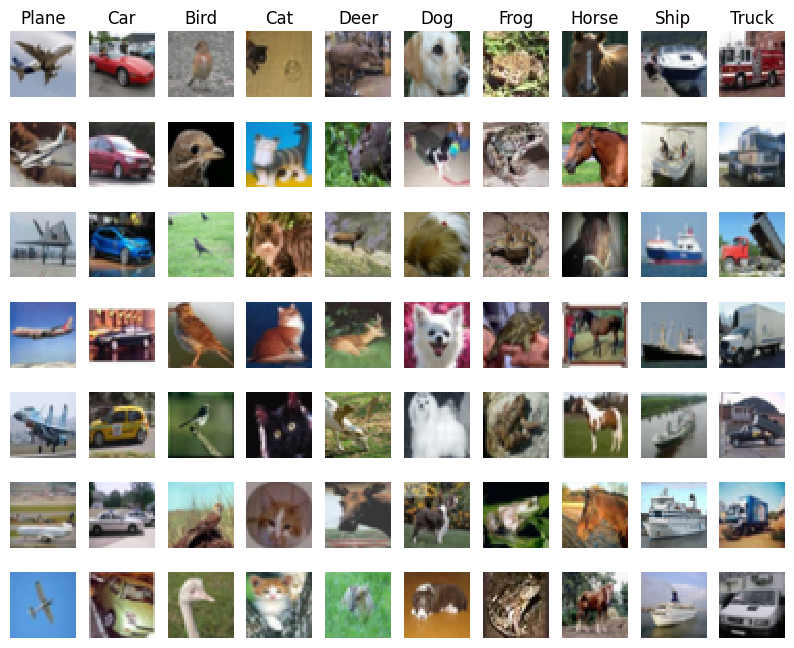

In [ ]:
# Visualize some examples from the dataset (few examples of training images from each class).
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls[:7])
plt.show()

## Split Data

Let's split our data!

In [ ]:
# Split the data into train, val, and test sets. In addition we will create a small development set as a subset of the training data. We can use this for development so our code runs faster.
num_training = 45000
num_validation = 5000
num_test = 10000
num_dev = 500

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000,)
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


Let's reshape the data into row vectors (flattening).

In [ ]:
# Preprocessing: reshape the image data into rows.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data.
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (45000, 3072)
Validation data shape:  (5000, 3072)
Test data shape:  (10000, 3072)
dev data shape:  (500, 3072)


## Pre-process data

Let's normalize our dataset.

Some of the elements of the mean image:
[130.81026667 136.10006667 132.57751111 130.21462222 135.4506
 131.84097778 131.12795556 136.25024444 132.56973333 131.65686667]
The mean image of our train set:


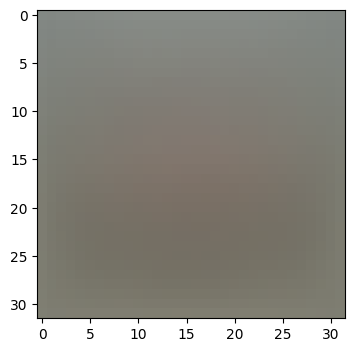

In [ ]:
# Preprocessing: subtract the mean image.

# Compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)

# Visualize some of its elements and the image itself.
print('Some of the elements of the mean image:')
print(mean_image[:10]) # Print few of the elements.
print('The mean image of our train set:')
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # Visualize the mean image.
plt.show()

# Subtract the mean image from train and test data.
mean_image = mean_image.astype('uint8')
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our SVM only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

Let's see our arrays' new shapes after bias trick.

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(45000, 3073) (5000, 3073) (10000, 3073) (500, 3073)


## SVM Classifier

### Forward and Backward (naive)

We implement both the forward pass (computing the loss) and the backward pass (gradient computation) for the structured SVM loss function. Ww write our code inside the function `svm_loss_naive()` in `engine/classifiers/linear_svm.py`. The forward pass computes the SVM loss, and the backward pass computes the gradient of the loss with respect to the weights.

To implement the gradient, we use this:

$\nabla_{w_{y_{i}}} L_{i} = - \left( \sum_{j \neq i} \mathbf{1}(s_{j} - s_{y_{i}} + 1 > 0) \right) x_{i}$,

and

$\nabla_{w_{j}} L_{i} = \mathbf{1}(s_{j} - s_{y_{i}} + 1 > 0) x_{i}$,

where: $s_{j} = w_{j}^Tx_{i}$, $s_{y_{i}} = w_{y_{i}}^Tx_{i}$,

$\mathbf{1}$ is the indicator function that is $\bf{one}$ if the condition inside is $\bf{True}$, or $\bf{zero}$ if the condition is $\bf{False}$.

### Gradient Check

To verify that our computed gradient is correct, we use a technique called numerical gradient checking. This process involves estimating the gradient of the loss function by slightly perturbing the weights and measuring the resulting change in the loss. Then, we compare this numerically estimated gradient with the gradient you computed analytically.

Here's a breakdown of why and how we do this:

- **Analytic Gradient** (Backward Pass):
The analytic gradient, which you computed in the `svm_loss_naive` function, is derived using calculus directly on the loss function. This is efficient and exact (in theory), but it can be error-prone, especially in implementations with complex functions.
- **Numerical Gradient**:
The numerical gradient approximates the gradient by using a small value (called epsilon) to slightly change each weight in $W$ and observe the change in loss. For a weight $W_{ij}$, the numerical gradient is calculated as:

$\frac{\partial L}{\partial W_{ij}} \approx \frac{L(W + \epsilon) - L(W - \epsilon)}{2 \epsilon}$,

where $\epsilon$ is a small value (e.g., $10^{-5}$).

By comparing the analytic gradient to the numerical gradient, we check if our analytic calculations are correct. Small differences are expected due to numerical approximation errors, but if there are large discrepancies, it likely means there is an error in our analytic computation.

In [ ]:
# Once we've implemented the gradient, we recompute it with the code below.

# Generate a random SVM weight matrix of small numbers.
W = np.random.randn(3073, 10) * 0.0001

# Compute the loss and its gradient at W.
from engine.classifiers.linear_svm import svm_loss_naive

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and compare them with your analytically computed gradient. The numbers must match almost exactly along all dimensions.
from engine.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Do the gradient check once again with regularization turned on.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 11.928000 analytic: 11.928000, relative error: 4.423840e-12
numerical: -16.536000 analytic: -16.536000, relative error: 1.332912e-12
numerical: -40.048079 analytic: -39.998000, relative error: 6.256225e-04
numerical: -7.554000 analytic: -7.554000, relative error: 5.242945e-12
numerical: 10.584000 analytic: 10.584000, relative error: 1.772044e-11
numerical: 21.220000 analytic: 21.220000, relative error: 8.381190e-12
numerical: 3.792000 analytic: 3.792000, relative error: 6.408733e-11
numerical: -1.146000 analytic: -1.146000, relative error: 1.323924e-10
numerical: -0.224000 analytic: -0.224000, relative error: 4.228260e-09
numerical: 6.880000 analytic: 6.880000, relative error: 5.017007e-11
numerical: 15.269980 analytic: 15.269980, relative error: 1.358548e-11
numerical: -0.748945 analytic: -0.748945, relative error: 5.801004e-11
numerical: -7.487911 analytic: -7.487911, relative error: 1.098825e-11
numerical: 4.828410 analytic: 4.828410, relative error: 4.173679e-11
numerica

### Forward and Backward (vectorized)

We implement the SVM loss function, but this time use vector/matrix products/multiplications instead of loops. This vectorized version is inside the ``svm_loss_vectorized()`` function of ``engine/classifiers/linear_svm.py``.

Inputs and outputs are the same as in ``svm_loss_naive``.

In [ ]:
# Implement the function svm_loss_vectorized; for now only compute the loss; we will implement the gradient in a moment.
import time

tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from engine.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.878795e+00 computed in 0.201977s
Vectorized loss: 8.878795e+00 computed in 0.017608s
difference: 0.000000


We complete the implementation of ``svm_loss_vectorized()`` by computing the gradient of the loss function in a vectorized way.

In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed by the two implementations. The gradient on the other hand is a matrix, so we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.085777s
Vectorized loss and gradient: computed in 0.008091s
difference: 0.000000


### Stochastic Gradient Descent

We have vectorized and efficient expressions for the loss and the gradient.

Our gradient matches the numerical gradient.

We are therefore ready to use Stochastic Gradient Descent (SGD) to minimize the loss.

Our code for this part will be written inside `engine/classifiers/linear_classifier.py`. Inside its ``LinearClassifier.train()`` function, we implement SGD.

In [ ]:
# In the file linear_classifier.py, we implement SGD in the function LinearClassifier.train() and then run it with the code below.
from engine.classifiers.linear_classifier import LinearSVM

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 791.471632
iteration 100 / 1500: loss 287.739249
iteration 200 / 1500: loss 108.325154
iteration 300 / 1500: loss 42.520394
iteration 400 / 1500: loss 18.860476
iteration 500 / 1500: loss 10.208400
iteration 600 / 1500: loss 7.782899
iteration 700 / 1500: loss 5.966214
iteration 800 / 1500: loss 5.265104
iteration 900 / 1500: loss 5.270555
iteration 1000 / 1500: loss 5.628574
iteration 1100 / 1500: loss 5.836501
iteration 1200 / 1500: loss 5.514047
iteration 1300 / 1500: loss 5.209939
iteration 1400 / 1500: loss 5.714773
That took 7.484937s


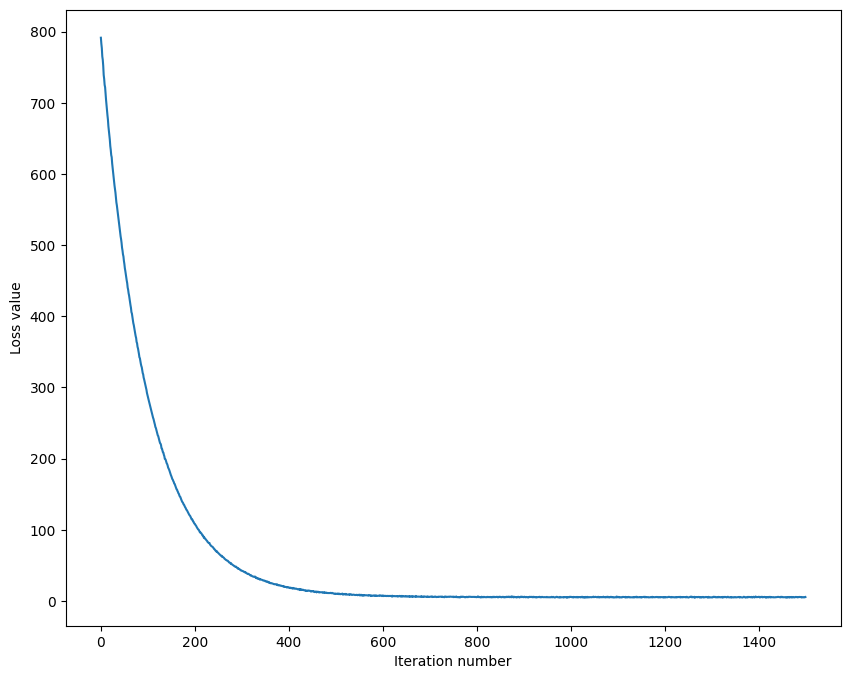

In [ ]:
# A useful debugging strategy is to plot the loss as a function of iteration number.
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Predict

Inside the `engine/classifiers/linear_classifier.py`, we write the ``LinearClassification.predict()`` function to evaluate the performance of the model.

In [ ]:
# Write the LinearClassification.predict function and evaluate the performance on both the training and validation set.
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.372222
validation accuracy: 0.360000


### Hyperparameter search

Now, we write code that chooses the best hyperparameters by tuning on the validation set (grid search).

Our goal is to perform a real-world training in order to save the SVM mobel that performs the best on validation set.

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and learning rate). We experiment with different ranges for the learning rates and regularization strengths.

# results is dictionary mapping tuples of the form (learning_rate, regularization_strength) to tuples of the form (training_accuracy, validation_accuracy). The accuracy is simply the fraction of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

# Provided hyperparameters.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# Loop over all learning_rates and regularization_strengths to take all possible combinations.
for lr in learning_rates:
    for reg in regularization_strengths:
        # Create a linear svm instance.
        svm = LinearSVM()

        # Train the model.
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, batch_size = 32, verbose=True)

        # Compute the training and validation accuracy.
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        # Store the results.
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Keep best val accuracy and best model(=best combiination of lr and reg).
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 1500: loss 807.161569
iteration 100 / 1500: loss 289.351739
iteration 200 / 1500: loss 113.442966
iteration 300 / 1500: loss 43.961900
iteration 400 / 1500: loss 20.492266
iteration 500 / 1500: loss 12.649794
iteration 600 / 1500: loss 7.750407
iteration 700 / 1500: loss 6.774920
iteration 800 / 1500: loss 6.589521
iteration 900 / 1500: loss 6.062522
iteration 1000 / 1500: loss 6.161185
iteration 1100 / 1500: loss 6.052906
iteration 1200 / 1500: loss 4.999241
iteration 1300 / 1500: loss 5.935794
iteration 1400 / 1500: loss 6.547476
iteration 0 / 1500: loss 1549.552258
iteration 100 / 1500: loss 207.441189
iteration 200 / 1500: loss 34.248607
iteration 300 / 1500: loss 8.596783
iteration 400 / 1500: loss 6.524903
iteration 500 / 1500: loss 5.890906
iteration 600 / 1500: loss 7.750853
iteration 700 / 1500: loss 6.373900
iteration 800 / 1500: loss 5.781646
iteration 900 / 1500: loss 5.616354
iteration 1000 / 1500: loss 6.386980
iteration 1100 / 1500: loss 4.614821
iteration 

/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/linear_svm.py:124: RuntimeWarning: overflow encountered in scalar multiply
  loss = np.sum(total_score) / X.shape[0] + reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/linear_svm.py:124: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(total_score) / X.shape[0] + reg * np.sum(W * W)
/content/drive/MyDrive/labs/lab_1_2024_2025/engine/classifiers/linear_svm.py:124: RuntimeWarning: overflow encountered in scalar multiply
  loss = np.sum(total_score) / X.shape[0] + reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/MyDrive/labs/lab_1_2024_2025/engin

iteration 0 / 1500: loss 1560.997457
iteration 100 / 1500: loss 4459930398576730318927307411570736737587457388074405671007540693478835859782796168496876415306954286316802669438229513502720.000000
iteration 200 / 1500: loss 11516654728000859500592805748874034688852028042904947304668545157603456724562145682486000270177679081752756511879773669036336131075205743811009146939583917816623536499096976293860258256156726141071121876582339078075039088806246452274825757982720.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.336622 val accuracy: 0.337800
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.328622 val accu

### Visualization of search results

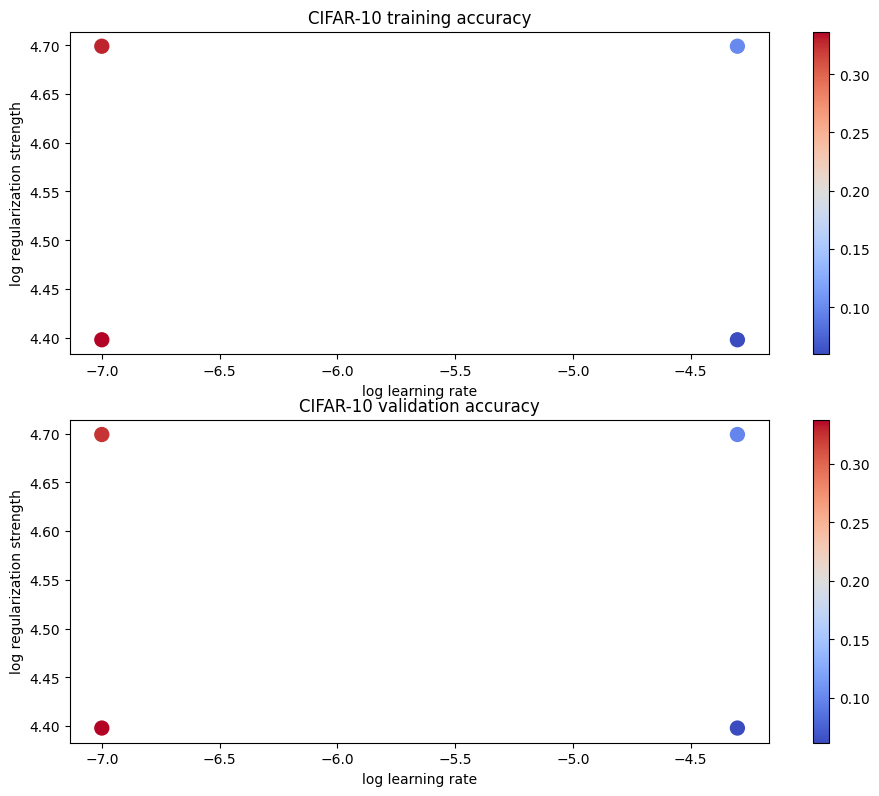

In [ ]:
# Visualize the results.
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Plot training accuracy.
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# Plot validation accuracy.
colors = [results[x][1] for x in results] # Default size of markers is 20.
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

### Predict on test set (unseen images)

Let's see how our model performs on unseen images - the test set.

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

Linear SVM on raw pixels final test set accuracy: 0.328500


### Visualization of learned weights for each class

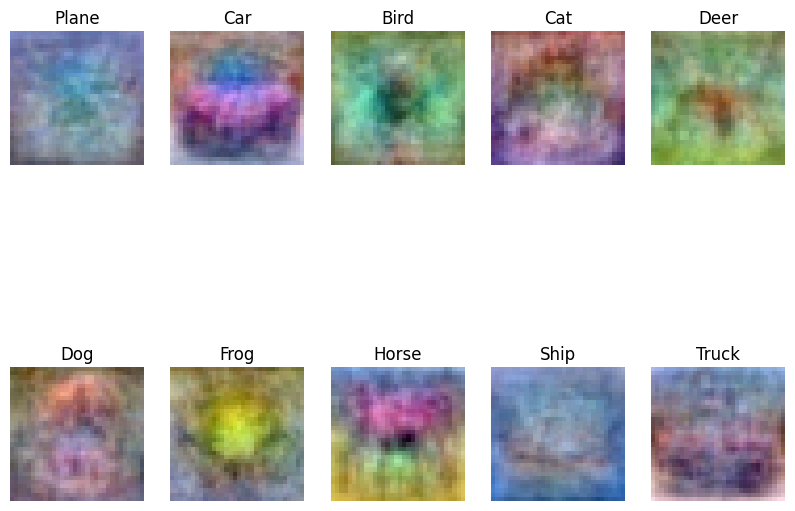

In [ ]:
# Visualize the learned weights for each class.
w = best_svm.W[:-1,:] # Strip out the bias.
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255.
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

We have 10 weight vectors as output, the same as the number of classes, as is expected. So, each best weight vector represents the basic features of each class. For example, as we can see above, most common shapes(for horse, car and deer mainly), or colors(for frog, ship and plane) are, not so easy, observable. Generally, SVM's purpose is to maximize the margin(distance) between the classes and, as knn is has to do with distances, no deeper meaning can be retrieved for such data like images. Mayabe, SVM is better on other kind of data or, better still, images need better model architectures, like CNNs, to be classified.